In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
train_csv = pd.read_csv('/kaggle/input/deep-past-initiative-machine-translation/train.csv')
train_csv.head()

,oare_id,transliteration,translation
0,004a7dbd-57ce-46f8-9691-409be61c676e,KIŠIB ma-nu-ba-lúm-a-šur DUMU ṣí-lá-(d)IM KIŠI...,"Seal of Mannum-balum-Aššur son of Ṣilli-Adad, ..."
1,0064939c-59b9-4448-a63d-34612af0a1b5,1 TÚG ša qá-tim i-tur₄-DINGIR il₅-qé,Itūr-ilī has received one textile of ordinary ...
2,0073f2c0-524c-4bbf-915a-8c1772a4fb98,TÚG u-la i-dí-na-ku-um i-tù-ra-ma 9 GÍN KÙ.BABBAR,... he did not give you a textile. He returned...
3,009fb838-8038-42bc-ad34-5f795b3840ee,KIŠIB šu-(d)EN.LÍL DUMU šu-ku-bi-im KIŠIB ṣí-l...,"Seal of Šu-Illil son of Šu-Kūbum, seal of Ṣilū..."
4,00aa1c55-c80c-4346-a159-73ad43ab0ff7,um-ma šu-ku-tum-ma a-na IŠTAR-lá-ma-sí ù ni-ta...,From Šukkutum to Ištar-lamassī and Nitahšušar:...


In [3]:
test_csv = pd.read_csv('/kaggle/input/deep-past-initiative-machine-translation/test.csv')
test_csv.head()

,id,text_id,line_start,line_end,transliteration
0,0,332fda50,1,7,um-ma kà-ru-um kà-ni-ia-ma a-na aa-qí-il… da-t...
1,1,332fda50,7,14,i-na mup-pì-im aa a-lim(ki) ia-tù u„-mì-im a-n...
2,2,332fda50,14,24,ki-ma mup-pì-ni ta-áa-me-a-ni a-ma-kam lu a-na...
3,3,332fda50,25,30,me-+e-er mup-pì-ni a-na kà-ar kà-ar-ma ú wa-ba...


In [4]:
samp_sub = pd.read_csv('/kaggle/input/deep-past-initiative-machine-translation/sample_submission.csv')
samp_sub.head()

,id,translation
0,0,"Thus Kanesh, say to the -payers, our messenge..."
1,1,In the letter of the City (it is written): Fro...
2,2,"As soon as you have heard our letter, who(ever..."
3,3,Send a copy of (this) letter of ours to every ...


In [5]:
lexicon_csv = pd.read_csv('/kaggle/input/deep-past-initiative-machine-translation/OA_Lexicon_eBL.csv')
lexicon_csv.head()

,type,form,norm,lexeme,eBL,I_IV,A_D,Female(f),Alt_lex
0,word,áb ša-ra-ni,ab šarrānē,ab šarrānē,https://www.ebl.lmu.de/dictionary?word=ab šarrānē,NaN,NaN,NaN,NaN
1,word,áb ša-ra-nim,ab šarrānem,ab šarrānē,https://www.ebl.lmu.de/dictionary?word=ab šarrānē,NaN,NaN,NaN,NaN
2,word,áb-ša-ra-nim,ab šarrānem,ab šarrānē,https://www.ebl.lmu.de/dictionary?word=ab šarrānē,NaN,NaN,NaN,NaN
3,word,áb-ša-ra-ni,ab šarrānē,ab šarrānē,https://www.ebl.lmu.de/dictionary?word=ab šarrānē,NaN,NaN,NaN,NaN
4,word,áb-ša-ra-ni₇,ab šarrānē,ab šarrānē,https://www.ebl.lmu.de/dictionary?word=ab šarrānē,NaN,NaN,NaN,NaN


In [6]:
bibliography_csv = pd.read_csv('/kaggle/input/deep-past-initiative-machine-translation/bibliography.csv')
bibliography_csv.head()

,pdf_name,title,author,author_place,journal,volume,year,pages
0,"(OCR) AfO 51, 2005-06, pp. 247-249 - Kryszat, ...",Kleine Mitteilungen,Guido Kryszat,Mainz,Archiv für Orientforschung,51,2005/2006,247–249
1,"(OCR) CDOG 8, 2008, pp. 109-124 - Dercksen, J....",The Assyrian Colony at Kanesh,Jan Gerrit Dercksen,Leiden,NaN,NaN,2008,NaN
2,"(OCR) JCS 59, 2007, pp. 93-106 - Larsen, Mogen...",Individual and Family in Old Assyrian Society,Mogens Trolle Larsen,Copenhagen,JCS,59,2007,93–95
3,27_arastirma_3-libre.pdf,Ege-Akdeniz Bölgesi Sualtı Araştırması 2008 Yı...,"Dr. Haydar Dönmez, Candaş Keskin, Necdet Çeliktaş",Ankara,Araştırma Sonuçları Toplantısı,3,2009,1–397
4,28_arastirma_3-libre.pdf,Kültür Varlıkları ve Müzeler Genel Müdürlüğü A...,"A. Naci TOY, Candaş KESKİN, Mustafa ÜÇGÜL, Fet...",İstanbul,Araştırma Sonuçları,3,2010,1–397


In [7]:
pub_csv = pd.read_csv('/kaggle/input/deep-past-initiative-machine-translation/publications.csv')
pub_csv.head()

,pdf_name,page,page_text,has_akkadian
0,"(OCR) AfO 51, 2005-06, pp. 247-249 - Kryszat, ...",1,Kleine Mitteilungen\nAltassyrische Miszellen 2...,False
1,"(OCR) AfO 51, 2005-06, pp. 247-249 - Kryszat, ...",2,248\nKleine Mitteilungen\nKleine Mitteilungen\...,False
2,"(OCR) AfO 51, 2005-06, pp. 247-249 - Kryszat, ...",1,Kleine Mitteilungen\nAltassyrische Miszellen 2...,False
3,"(OCR) AfO 51, 2005-06, pp. 247-249 - Kryszat, ...",2,248\nKleine Mitteilungen\nKleine Mitteilungen\...,False
4,"(OCR) CDOG 8, 2008, pp. 109-124 - Dercksen, J....",1,THE AssYRIAN COLONY AT KANEsH\nJan Gerrit Derc...,False


In [8]:
pub_txt_csv = pd.read_csv('/kaggle/input/deep-past-initiative-machine-translation/published_texts.csv')
pub_txt_csv.head()

,oare_id,online transcript,cdli_id,aliases,label,publication_catalog,description,genre_label,inventory_position,online_catalog,note,interlinear_commentary,online_information,excavation_no,oatp_key,eBL_id,AICC_translation,transliteration_orig,transliteration
0,bd4b7138-70d5-490d-8234-299b0a75d3a3,https://oare.byu.edu/epigraphies/bd4b7138-70d5...,P361099,MP 1 bis,Cuneiform Tablet RA 60 125,RA 60 125,"Cuneiform envelope, dated to the Old Assyrian ...",letter,MP 1 bis,NaN,Collection: MP 1 bis,"P. Garelli RA 60 S. 124-125; Michel Innaya II,...",NaN,NaN,4395,NaN,https://aicuneiform.com/search?q=P361099,KIŠIB a-šùr-ma-lik DUMU i-na-a a-na a-šùr-na-d...,KIŠIB a-šùr-ma-lik DUMU i-na-a a-na a-šùr-na-d...
1,b05376c2-fc3d-49f8-9792-a25c0df9c383,https://oare.byu.edu/epigraphies/b05376c2-fc3d...,P359543,ICK 1 146,Cuneiform Tablet ICK 1 146,Ka 185 | Ka 455 | Ka 424?,"Cuneiform tablet, dated to the Old Assyrian Pe...",debt note,Ist Ka 185 | Ist Ka 455 | Ist Ka 424?,NaN,"ICK 1, 146 & ICK 2, 33 (env) + ICK 2, 163 (env)","Ichisar, Imdilum 65f.",NaN,NaN,1888,NaN,https://aicuneiform.com/search?q=P359543,0.33333 ma-na 7 GÍN KÙ.BABBAR ṣa-ru-pá-am i-ṣé...,0.33333 ma-na 7 GÍN KÙ.BABBAR ṣa-ru-pá-am i-ṣé...
2,80547963-f2a2-4d5d-9544-fc7ada60d3b2,https://oare.byu.edu/epigraphies/80547963-f2a2...,P361681,TrMA 1 | Or 36 396 n. 2,Cuneiform Tablet Or 36 396A.2,NaN,"Cuneiform tablet, dated to the Old Assyrian Pe...",debt note,TrMA 1,NaN,Or 36 396 n. 2,NaN,NaN,NaN,56,NaN,https://aicuneiform.com/search?q=P361681,{large break} a-na a-lá-lá-ma-sí ù a-mur-DINGI...,<big_gap> a-na a-lá-lá-ma-sí ù a-mur-DINGIR qí...
3,8c0d4238-f795-4061-8b3c-8469a66d86d6,https://oare.byu.edu/epigraphies/8c0d4238-f795...,P361098,MP 1,Cuneiform Tablet RA 60 123,RA 60 123,"Cuneiform tablet, dated to the Old Assyrian Pe...",letter,MP 1,NaN,NaN,NaN,NaN,NaN,4394,NaN,https://aicuneiform.com/search?q=P361098,um-ma PUZUR₄-a-šùr-ma a-na bu-za-zu qí-bi-ma a...,um-ma PUZUR₄-a-šùr-ma a-na bu-za-zu qí-bi-ma a...
4,2c0d870b-cd5e-fc36-8d81-114ecc7a9ac4,https://oare.byu.edu/epigraphies/2c0d870b-cd5e...,P290300,CCT 6 17a,Cuneiform Tablet CCT 6 17a (BM 115099),NaN,"Cuneiform tablet, dated to the Old Assyrian Pe...",unknown,BM 115099,NaN,"CCT 6, 17a","EL 320; 2-7: Garelli, AC 176A.4; 29-32: ebd. 3...",NaN,NaN,1603,NaN,https://aicuneiform.com/search?q=P290300,bu-za-zu il₅-we-da-ku iš-a-al-ma um-ma bu-za-z...,bu-za-zu il₅-we-da-ku iš-a-al-ma um-ma bu-za-z...


In [9]:
train_csv.shape

(1561, 3)

In [10]:
print("\\nData types:")
print(train_csv.dtypes)

\nData types:
oare_id            object
transliteration    object
translation        object
dtype: object


In [11]:
print("===Dataset Overview===")
print("sample train size:", len(train_csv))
print("sample test size:", len(test_csv))

===Dataset Overview===
sample train size: 1561
sample test size: 4


In [12]:
print("=== MISSING VALUES ===")
print("Train missing values:")
print(train_csv.isnull().sum())
print("\\nTest missing values:")
print(test_csv.isnull().sum())

=== MISSING VALUES ===
Train missing values:
oare_id            0
transliteration    0
translation        0
dtype: int64
\nTest missing values:
id                 0
text_id            0
line_start         0
line_end           0
transliteration    0
dtype: int64


In [13]:
print("<=== Fourth Row of Transliteration:")
print(train_csv['transliteration'][3])

<=== Fourth Row of Transliteration:
KIŠIB šu-(d)EN.LÍL DUMU šu-ku-bi-im KIŠIB ṣí-lu-lu DUMU ú-ku i-nu-mì i-dí-a-bu-um a-wa-sú iq-bi-ú 10 ma-na KÙ.BABBAR a-na ša-lim-a-šùr i-dí-in um-ma šu-ut-ma i-ṣí-ba-at KÙ-pì-a li-il₅-qé


In [14]:
print("Split fourth row on tokens....")
print(train_csv['transliteration'][3].split())
print(f"Number of tokens: {len(train_csv['transliteration'][3].split())}")

Split fourth row on tokens....
['KIŠIB', 'šu-(d)EN.LÍL', 'DUMU', 'šu-ku-bi-im', 'KIŠIB', 'ṣí-lu-lu', 'DUMU', 'ú-ku', 'i-nu-mì', 'i-dí-a-bu-um', 'a-wa-sú', 'iq-bi-ú', '10', 'ma-na', 'KÙ.BABBAR', 'a-na', 'ša-lim-a-šùr', 'i-dí-in', 'um-ma', 'šu-ut-ma', 'i-ṣí-ba-at', 'KÙ-pì-a', 'li-il₅-qé']
Number of tokens: 23


In [15]:
print("==== Token count in train set (transliteration) ====")
train_csv['transliteration'].apply(lambda x: len(str(x).split()))

==== Token count in train set (transliteration) ====


0       50
1        6
2        7
3       23
4       77
        ..
1556    72
1557    21
1558    88
1559    75
1560    92
Name: transliteration, Length: 1561, dtype: int64

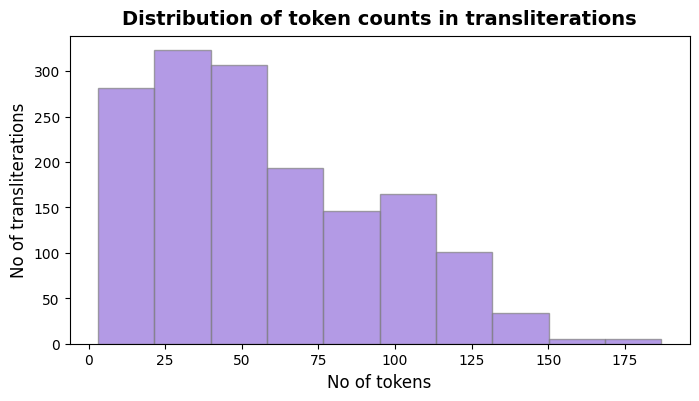

In [16]:
barplot_specs = {"color": "mediumpurple", "alpha": 0.7, "edgecolor": "grey"}
label_specs   = {"fontsize": 12}
title_specs   = {"fontsize": 14, "fontweight": "bold", "y": 1.01}

plt.figure(figsize=(8,4))

plt.hist(train_csv['transliteration'].apply(lambda x:len(str(x).split())), **barplot_specs)
plt.xlabel('No of tokens', **label_specs)
plt.ylabel('No of transliterations',**label_specs)
plt.title('Distribution of token counts in transliterations',**title_specs)
plt.show()

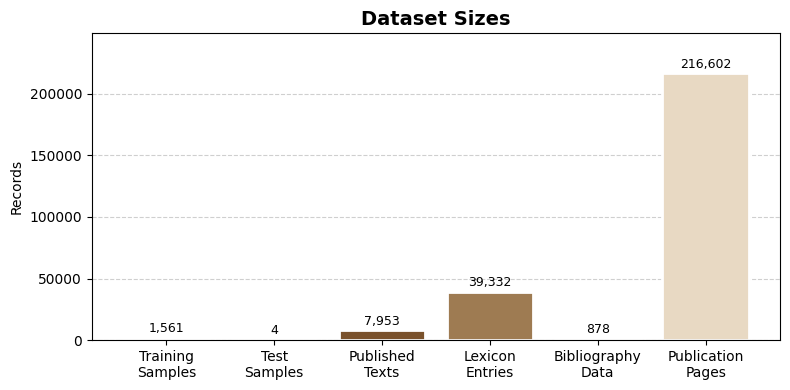

In [17]:
fig, ax = plt.subplots(figsize=(8,4))

sizes = [len(train_csv), len(test_csv), len(pub_txt_csv), len(lexicon_csv), len(bibliography_csv), len(pub_csv)]
names = ['Training\nSamples', 'Test\nSamples', 'Published\nTexts', 'Lexicon\nEntries', 'Bibliography\nData', 'Publication\nPages']
colors = ['#2e1a0b', '#553312', '#7a522c', '#9e7b52', '#c3a985', '#e8d9c3']

bars = ax.bar(names, sizes, color=colors, edgecolor='white', linewidth=2)


ax.yaxis.grid(True, linestyle='--', alpha=0.6)
ax.set_axisbelow(True)  


for bar, size in zip(bars, sizes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sizes)*0.01, 
            f'{size:,}', ha='center', va='bottom', fontsize=9)

ax.set_ylabel('Records', fontsize=10)
ax.set_title('Dataset Sizes', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(sizes) * 1.15)


plt.tight_layout()
plt.show()


In [18]:
print("Test data can be decomposed down to segments....")
print("Segment Details:")
print("-"* 50)
for _, row in test_csv.iterrows():
    print(f"ID {row['id']}: Lines {row['line_start']:2d}-{row['line_end']:2d} | {len(row['transliteration']):3d} chars")


Test data can be decomposed down to segments....
Segment Details:
--------------------------------------------------
ID 0: Lines  1- 7 | 133 chars
ID 1: Lines  7-14 | 146 chars
ID 2: Lines 14-24 | 267 chars
ID 3: Lines 25-30 | 129 chars


In [19]:
full_test_text = ' '.join(test_csv['transliteration'].tolist())

vectorizer = TfidfVectorizer(
    analyzer = 'char_wb',
    ngram_range = (2,6),
    max_features = 25000,
    sublinear_tf = True
)

train_vectors = vectorizer.fit_transform(train_csv['transliteration'].str.lower())
test_vector = vectorizer.transform([full_test_text.lower()])

print(f"Vocabulary size: {len(vectorizer.vocabulary_):,} character n-grams")


Vocabulary size: 25,000 character n-grams


In [20]:
similarities = cosine_similarity(test_vector,train_vectors)[0]

top_k = 5
top_indices = similarities.argsort()[-top_k:][::-1]

print(f"Top {top_k} Most Similar Training Samples")
print("=" * 60)

for rank, idx in enumerate(top_indices, 1):
    sim = similarities[idx]
    preview = train_csv.iloc[idx]['transliteration'][:70]
    print(f"{rank}. Similarity: {sim:.1%}")
    print(f"      {preview}...")
    print()

Top 5 Most Similar Training Samples
1. Similarity: 87.2%
      um-ma kà-ru-um kà-ni-iš-ma a-na ša-qí-il₅ da-tim ší-ip-ri-ni kà-ar kà-...

2. Similarity: 39.8%
      um-ma kà-ru-um kà-ni-iš-ma a-na ša-qí-il₅ da-tim ku-li-a ší-ip-ri-ni w...

3. Similarity: 36.3%
      um-ma kà-ru-um kà-ni-iš-ma a-na ša-qí-il₅ da-tim ku-li-a ší-ip-ri-ni k...

4. Similarity: 33.0%
      um-ma kà-ru-um kà-ni-iš-ma a-na ku-li-a ší-ip-ri-ni kà-ar kà-ar-ma a-l...

5. Similarity: 31.3%
      KIŠIB ša-qí-il₅ da-tim ku-li-a ší-ip-ri-im ša kà-ri-im kà-ni-iš ù kà-r...



In [21]:
best_idx = top_indices[0]
best_similarity = similarities[best_idx]
best_transliteration = train_csv.iloc[best_idx]['transliteration']
best_translation = train_csv.iloc[best_idx]['translation']

print(f"🎯 Best Match Found!")
print(f"   Similarity: {best_similarity:.1%}")
print()
print("=" * 70)
print("AKKADIAN (Transliteration)")
print("=" * 70)
print(best_transliteration)
print()
print("=" * 70)
print("ENGLISH (Translation)")
print("=" * 70)
print(best_translation)

🎯 Best Match Found!
   Similarity: 87.2%

AKKADIAN (Transliteration)
um-ma kà-ru-um kà-ni-iš-ma a-na ša-qí-il₅ da-tim ší-ip-ri-ni kà-ar kà-ar-ma ú wa-bar-ra-tim qí-bi₄-ma ṭup-pu-um ša a-lim(ki) i-li-kam i-na ṭup-pì-im ša a-lim(ki) iš-tù u₄-mì-im a-nim ma-ma-an KÙ.AN i-ša-ú-mu-ni i-na né-mì-lim da-šùr ú-lá e-WA iš-ra-tí-šu kà-ru-um kà-ni-iš i-lá-qé ki-ma ṭup-pì-ni ta-áš-me-a-ni a-ma-kam lu a-na ší-mì-im a-na É.GAL-lim i-dí-in lu té-ra-at É.GAL-lim ú-kà-lim lu na-ší-ma a-dí-ni lá i-dí-in ma-lá KÙ.AN na-áš-ú ni-bi₄-it a-ší-im šu-um-šu ú šu-mì a-bi₄-šu i-na ṭup-pì-im lu-up-ta-nim-ma iš-tí ší-ip-ri-ni šé-bi₄-lá-nim me-ḫe-er ṭup-pì-ni a-na kà-ar kà-ar-ma ú wa-bar-ra-tim šé-bi₄-lá KÙ.AN lu a-na DAM.GÀR-ru-tim i-dí-in šu-mì a-wi-lim lu-up-ta-nim

ENGLISH (Translation)
Thus  Kanesh, say to the -payers, our messenger, every single colony, and the trading stations: A letter of the City has arrived. In the letter of the City (it is written): From this day on, whoever buys meteoric iron, (the City 

In [22]:
def extract_translation_segment(translation, line_start, line_end, total_lines):
    """
    Extract a proportional segment from translation based on line numbers.
    Adjusts boundaries to align with sentence endings.
    
    Args:
        translation: Full translation text
        line_start: Starting line number of segment
        line_end: Ending line number of segment  
        total_lines: Total lines in the full text
    
    Returns:
        Extracted translation segment with clean boundaries
    """
    # Calculate proportional character positions
    start_ratio = (line_start - 1) / total_lines
    end_ratio = line_end / total_lines
    
    start_char = int(len(translation) * start_ratio)
    end_char = int(len(translation) * end_ratio)
    
    # Adjust start to nearest sentence boundary (look back up to 100 chars)
    if start_char > 0:
        search_start = max(0, start_char - 100)
        last_period = translation.rfind('.', search_start, start_char)
        if last_period > 0:
            start_char = last_period + 2  # Skip period and space
    
    # Adjust end to nearest sentence boundary (look forward up to 100 chars)
    if end_char < len(translation):
        search_end = min(len(translation), end_char + 100)
        next_period = translation.find('.', end_char, search_end)
        if next_period > 0:
            end_char = next_period + 1
    
    return translation[start_char:end_char].strip()

print("✅ Segmentation function ready!")

✅ Segmentation function ready!


In [23]:
total_lines = test_csv['line_end'].max()



predictions = []

for _, row in test_csv.iterrows():
    
    segment = extract_translation_segment(
        translation=best_translation,
        line_start=row['line_start'],
        line_end=row['line_end'],
        total_lines=total_lines
    )
    predictions.append(segment)   

In [24]:
submission_df = pd.DataFrame({
    'id': test_csv['id'],
    'translation': predictions
})

submission_df.head()

,id,translation
0,0,"Thus Kanesh, say to the -payers, our messenge..."
1,1,In the letter of the City (it is written): Fro...
2,2,"As soon as you have heard our letter, who(ever..."
3,3,Send a copy of (this) letter of ours to every ...


In [25]:
submission_df.to_csv('submission.csv',index=False)